<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[09:13:59] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


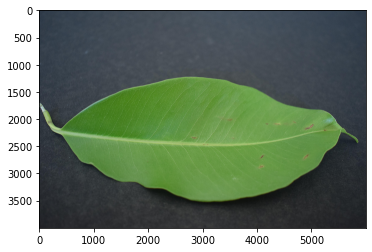

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

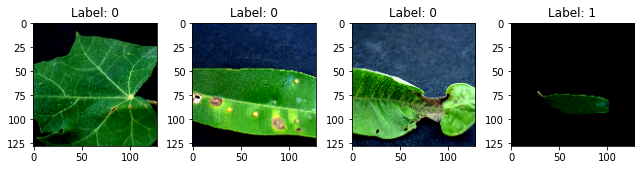

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[09:14:05] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[09:14:07] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2231746211120123 samples/sec                   batch loss = 1.5384654998779297 | accuracy = 0.55


Epoch[1] Batch[10] Speed: 1.2561595913853882 samples/sec                   batch loss = 0.2800914943218231 | accuracy = 0.675


Epoch[1] Batch[15] Speed: 1.2594716082780684 samples/sec                   batch loss = 0.6704584956169128 | accuracy = 0.6833333333333333


Epoch[1] Batch[20] Speed: 1.2658027902077906 samples/sec                   batch loss = 0.783636212348938 | accuracy = 0.6625


Epoch[1] Batch[25] Speed: 1.269765403322993 samples/sec                   batch loss = 1.1340394020080566 | accuracy = 0.67


Epoch[1] Batch[30] Speed: 1.2619506360030475 samples/sec                   batch loss = 1.5844578742980957 | accuracy = 0.6583333333333333


Epoch[1] Batch[35] Speed: 1.2650193954073834 samples/sec                   batch loss = 0.550334632396698 | accuracy = 0.6357142857142857


Epoch[1] Batch[40] Speed: 1.2659156835705772 samples/sec                   batch loss = 0.319290429353714 | accuracy = 0.6625


Epoch[1] Batch[45] Speed: 1.2734612111684533 samples/sec                   batch loss = 0.7034291625022888 | accuracy = 0.6388888888888888


Epoch[1] Batch[50] Speed: 1.2724784439147385 samples/sec                   batch loss = 0.4399440288543701 | accuracy = 0.63


Epoch[1] Batch[55] Speed: 1.271328964580793 samples/sec                   batch loss = 0.46893346309661865 | accuracy = 0.6136363636363636


Epoch[1] Batch[60] Speed: 1.2674548350849222 samples/sec                   batch loss = 0.5999510884284973 | accuracy = 0.6208333333333333


Epoch[1] Batch[65] Speed: 1.2732290736298204 samples/sec                   batch loss = 0.8280726671218872 | accuracy = 0.6269230769230769


Epoch[1] Batch[70] Speed: 1.26772021774252 samples/sec                   batch loss = 0.6370844841003418 | accuracy = 0.625


Epoch[1] Batch[75] Speed: 1.264840957551513 samples/sec                   batch loss = 0.4974384009838104 | accuracy = 0.63


Epoch[1] Batch[80] Speed: 1.262796193851661 samples/sec                   batch loss = 0.5104787349700928 | accuracy = 0.628125


Epoch[1] Batch[85] Speed: 1.272174021641618 samples/sec                   batch loss = 0.9104607105255127 | accuracy = 0.6176470588235294


Epoch[1] Batch[90] Speed: 1.2699642670552787 samples/sec                   batch loss = 0.7863016128540039 | accuracy = 0.6194444444444445


Epoch[1] Batch[95] Speed: 1.27060924841973 samples/sec                   batch loss = 0.3608973026275635 | accuracy = 0.618421052631579


Epoch[1] Batch[100] Speed: 1.280677311334394 samples/sec                   batch loss = 0.430919885635376 | accuracy = 0.6325


Epoch[1] Batch[105] Speed: 1.2760177017130832 samples/sec                   batch loss = 0.48768240213394165 | accuracy = 0.6309523809523809


Epoch[1] Batch[110] Speed: 1.2737618013342857 samples/sec                   batch loss = 1.5083088874816895 | accuracy = 0.6295454545454545


Epoch[1] Batch[115] Speed: 1.2709935091302478 samples/sec                   batch loss = 0.3809312582015991 | accuracy = 0.6282608695652174


Epoch[1] Batch[120] Speed: 1.277573942913885 samples/sec                   batch loss = 0.7147719264030457 | accuracy = 0.6291666666666667


Epoch[1] Batch[125] Speed: 1.2733842736144771 samples/sec                   batch loss = 0.5206295251846313 | accuracy = 0.632


Epoch[1] Batch[130] Speed: 1.273470684022646 samples/sec                   batch loss = 0.7756659984588623 | accuracy = 0.6307692307692307


Epoch[1] Batch[135] Speed: 1.272567144555228 samples/sec                   batch loss = 0.6525952219963074 | accuracy = 0.6296296296296297


Epoch[1] Batch[140] Speed: 1.2712248321257724 samples/sec                   batch loss = 0.5253381729125977 | accuracy = 0.6321428571428571


Epoch[1] Batch[145] Speed: 1.2706857547561867 samples/sec                   batch loss = 0.626788318157196 | accuracy = 0.6327586206896552


Epoch[1] Batch[150] Speed: 1.2720786241680453 samples/sec                   batch loss = 0.8167701363563538 | accuracy = 0.6316666666666667


Epoch[1] Batch[155] Speed: 1.2732619272567514 samples/sec                   batch loss = 0.9142023921012878 | accuracy = 0.6306451612903226


Epoch[1] Batch[160] Speed: 1.2701568464903066 samples/sec                   batch loss = 0.6946974992752075 | accuracy = 0.634375


Epoch[1] Batch[165] Speed: 1.2710703506448304 samples/sec                   batch loss = 0.4742613136768341 | accuracy = 0.6348484848484849


Epoch[1] Batch[170] Speed: 1.2661726817836647 samples/sec                   batch loss = 0.49414369463920593 | accuracy = 0.6352941176470588


Epoch[1] Batch[175] Speed: 1.2615520913846132 samples/sec                   batch loss = 0.5393570065498352 | accuracy = 0.6342857142857142


Epoch[1] Batch[180] Speed: 1.266860976087316 samples/sec                   batch loss = 0.7241474390029907 | accuracy = 0.6347222222222222


Epoch[1] Batch[185] Speed: 1.2772258497073883 samples/sec                   batch loss = 0.6827225089073181 | accuracy = 0.6310810810810811


Epoch[1] Batch[190] Speed: 1.2713310840123289 samples/sec                   batch loss = 0.6258264183998108 | accuracy = 0.631578947368421


Epoch[1] Batch[195] Speed: 1.271970029293524 samples/sec                   batch loss = 0.41876187920570374 | accuracy = 0.6358974358974359


Epoch[1] Batch[200] Speed: 1.2681383897064498 samples/sec                   batch loss = 0.777202308177948 | accuracy = 0.6325


Epoch[1] Batch[205] Speed: 1.2710084337600402 samples/sec                   batch loss = 0.6993116736412048 | accuracy = 0.6304878048780488


Epoch[1] Batch[210] Speed: 1.268635495248822 samples/sec                   batch loss = 0.6543470025062561 | accuracy = 0.6345238095238095


Epoch[1] Batch[215] Speed: 1.262162631439414 samples/sec                   batch loss = 0.9036049842834473 | accuracy = 0.6383720930232558


Epoch[1] Batch[220] Speed: 1.258594710114344 samples/sec                   batch loss = 0.5696921348571777 | accuracy = 0.6363636363636364


Epoch[1] Batch[225] Speed: 1.2593404824900107 samples/sec                   batch loss = 0.8188028931617737 | accuracy = 0.6344444444444445


Epoch[1] Batch[230] Speed: 1.2690296975751383 samples/sec                   batch loss = 0.48767149448394775 | accuracy = 0.6315217391304347


Epoch[1] Batch[235] Speed: 1.2718846902064016 samples/sec                   batch loss = 0.37599000334739685 | accuracy = 0.6340425531914894


Epoch[1] Batch[240] Speed: 1.2715136706612058 samples/sec                   batch loss = 0.670337975025177 | accuracy = 0.634375


Epoch[1] Batch[245] Speed: 1.2743592452748784 samples/sec                   batch loss = 0.3461812734603882 | accuracy = 0.636734693877551


Epoch[1] Batch[250] Speed: 1.279050802066673 samples/sec                   batch loss = 0.5234576463699341 | accuracy = 0.638


Epoch[1] Batch[255] Speed: 1.2753978563678912 samples/sec                   batch loss = 0.3215271830558777 | accuracy = 0.6392156862745098


Epoch[1] Batch[260] Speed: 1.2757318578011858 samples/sec                   batch loss = 0.8031642436981201 | accuracy = 0.6394230769230769


Epoch[1] Batch[265] Speed: 1.2776566417185278 samples/sec                   batch loss = 0.5277355313301086 | accuracy = 0.6424528301886793


Epoch[1] Batch[270] Speed: 1.2747255352266327 samples/sec                   batch loss = 0.3160819709300995 | accuracy = 0.6425925925925926


Epoch[1] Batch[275] Speed: 1.278945693342852 samples/sec                   batch loss = 0.5363206267356873 | accuracy = 0.6454545454545455


Epoch[1] Batch[280] Speed: 1.2777061688340123 samples/sec                   batch loss = 0.30143314599990845 | accuracy = 0.6473214285714286


Epoch[1] Batch[285] Speed: 1.2716156336751196 samples/sec                   batch loss = 0.604579508304596 | accuracy = 0.6447368421052632


Epoch[1] Batch[290] Speed: 1.277383581770341 samples/sec                   batch loss = 0.45085760951042175 | accuracy = 0.6474137931034483


Epoch[1] Batch[295] Speed: 1.2734240944038602 samples/sec                   batch loss = 0.5146425366401672 | accuracy = 0.6491525423728813


Epoch[1] Batch[300] Speed: 1.2755389419070464 samples/sec                   batch loss = 0.4617701768875122 | accuracy = 0.6508333333333334


Epoch[1] Batch[305] Speed: 1.2819563056966052 samples/sec                   batch loss = 0.46308228373527527 | accuracy = 0.65


Epoch[1] Batch[310] Speed: 1.2736941102445989 samples/sec                   batch loss = 0.5724518895149231 | accuracy = 0.65


Epoch[1] Batch[315] Speed: 1.2765905510840418 samples/sec                   batch loss = 0.38034695386886597 | accuracy = 0.6492063492063492


Epoch[1] Batch[320] Speed: 1.2708986737054928 samples/sec                   batch loss = 0.7953829169273376 | accuracy = 0.64921875


Epoch[1] Batch[325] Speed: 1.2609812828953326 samples/sec                   batch loss = 0.8685545325279236 | accuracy = 0.6476923076923077


Epoch[1] Batch[330] Speed: 1.2630424182407567 samples/sec                   batch loss = 0.7751913070678711 | accuracy = 0.646969696969697


Epoch[1] Batch[335] Speed: 1.2649318391692708 samples/sec                   batch loss = 0.22967804968357086 | accuracy = 0.6477611940298508


Epoch[1] Batch[340] Speed: 1.2648476325669833 samples/sec                   batch loss = 0.8599207401275635 | accuracy = 0.6470588235294118


Epoch[1] Batch[345] Speed: 1.2616574914357743 samples/sec                   batch loss = 0.39559054374694824 | accuracy = 0.6492753623188405


Epoch[1] Batch[350] Speed: 1.2701198259389697 samples/sec                   batch loss = 1.0818365812301636 | accuracy = 0.65


Epoch[1] Batch[355] Speed: 1.2760790399737623 samples/sec                   batch loss = 0.48656758666038513 | accuracy = 0.6514084507042254


Epoch[1] Batch[360] Speed: 1.2700288703209497 samples/sec                   batch loss = 0.26712390780448914 | accuracy = 0.6520833333333333


Epoch[1] Batch[365] Speed: 1.2844981739949315 samples/sec                   batch loss = 0.6189893484115601 | accuracy = 0.6547945205479452


Epoch[1] Batch[370] Speed: 1.2792886767672516 samples/sec                   batch loss = 3.3528242111206055 | accuracy = 0.6554054054054054


Epoch[1] Batch[375] Speed: 1.2753827315234185 samples/sec                   batch loss = 0.9438729882240295 | accuracy = 0.658


Epoch[1] Batch[380] Speed: 1.276963276266386 samples/sec                   batch loss = 0.4724082946777344 | accuracy = 0.6585526315789474


Epoch[1] Batch[385] Speed: 1.2739096830392238 samples/sec                   batch loss = 0.6225232481956482 | accuracy = 0.6584415584415585


Epoch[1] Batch[390] Speed: 1.2767260711686668 samples/sec                   batch loss = 0.6448917984962463 | accuracy = 0.6583333333333333


Epoch[1] Batch[395] Speed: 1.2775796828380925 samples/sec                   batch loss = 0.8594626784324646 | accuracy = 0.6569620253164556


Epoch[1] Batch[400] Speed: 1.2748302420155446 samples/sec                   batch loss = 0.5949028730392456 | accuracy = 0.6575


Epoch[1] Batch[405] Speed: 1.2733519935401956 samples/sec                   batch loss = 0.4185200035572052 | accuracy = 0.6598765432098765


Epoch[1] Batch[410] Speed: 1.2757789074798067 samples/sec                   batch loss = 0.6510640382766724 | accuracy = 0.6615853658536586


Epoch[1] Batch[415] Speed: 1.2773128795364124 samples/sec                   batch loss = 0.41752785444259644 | accuracy = 0.6620481927710843


Epoch[1] Batch[420] Speed: 1.276289789592526 samples/sec                   batch loss = 0.7252078652381897 | accuracy = 0.6607142857142857


Epoch[1] Batch[425] Speed: 1.2722961590072928 samples/sec                   batch loss = 0.29875120520591736 | accuracy = 0.6617647058823529


Epoch[1] Batch[430] Speed: 1.2747464558371422 samples/sec                   batch loss = 0.5778933167457581 | accuracy = 0.663953488372093


Epoch[1] Batch[435] Speed: 1.2735555593510468 samples/sec                   batch loss = 0.49306777119636536 | accuracy = 0.6637931034482759


Epoch[1] Batch[440] Speed: 1.2763292097305898 samples/sec                   batch loss = 0.30701836943626404 | accuracy = 0.6647727272727273


Epoch[1] Batch[445] Speed: 1.2719162209419745 samples/sec                   batch loss = 0.5228952169418335 | accuracy = 0.6640449438202247


Epoch[1] Batch[450] Speed: 1.2733287992877282 samples/sec                   batch loss = 0.19355323910713196 | accuracy = 0.665


Epoch[1] Batch[455] Speed: 1.2804195710798483 samples/sec                   batch loss = 0.5405178070068359 | accuracy = 0.667032967032967


Epoch[1] Batch[460] Speed: 1.275679476674763 samples/sec                   batch loss = 0.6113170981407166 | accuracy = 0.6679347826086957


Epoch[1] Batch[465] Speed: 1.2723903346297234 samples/sec                   batch loss = 0.6019906997680664 | accuracy = 0.667741935483871


Epoch[1] Batch[470] Speed: 1.2720242279700098 samples/sec                   batch loss = 0.2568016052246094 | accuracy = 0.6691489361702128


Epoch[1] Batch[475] Speed: 1.274855040962084 samples/sec                   batch loss = 0.3111132085323334 | accuracy = 0.6694736842105263


Epoch[1] Batch[480] Speed: 1.278084121946106 samples/sec                   batch loss = 0.3896750807762146 | accuracy = 0.6703125


Epoch[1] Batch[485] Speed: 1.2687754723607587 samples/sec                   batch loss = 0.3721505403518677 | accuracy = 0.6695876288659793


Epoch[1] Batch[490] Speed: 1.2794914130964483 samples/sec                   batch loss = 0.712913453578949 | accuracy = 0.6688775510204081


Epoch[1] Batch[495] Speed: 1.2696655624242559 samples/sec                   batch loss = 1.0510938167572021 | accuracy = 0.6671717171717172


Epoch[1] Batch[500] Speed: 1.2665150622537322 samples/sec                   batch loss = 0.4911241829395294 | accuracy = 0.667


Epoch[1] Batch[505] Speed: 1.2664435504227816 samples/sec                   batch loss = 0.9686396718025208 | accuracy = 0.6673267326732674


Epoch[1] Batch[510] Speed: 1.2690732782992624 samples/sec                   batch loss = 0.5282142162322998 | accuracy = 0.6686274509803921


Epoch[1] Batch[515] Speed: 1.272041009279555 samples/sec                   batch loss = 0.42911407351493835 | accuracy = 0.6694174757281554


Epoch[1] Batch[520] Speed: 1.2761604775670732 samples/sec                   batch loss = 0.5247861742973328 | accuracy = 0.6706730769230769


Epoch[1] Batch[525] Speed: 1.272097239538278 samples/sec                   batch loss = 0.9655075669288635 | accuracy = 0.6704761904761904


Epoch[1] Batch[530] Speed: 1.2712138515291043 samples/sec                   batch loss = 0.5697451233863831 | accuracy = 0.6721698113207547


Epoch[1] Batch[535] Speed: 1.263920099762294 samples/sec                   batch loss = 0.2024368792772293 | accuracy = 0.6742990654205607


Epoch[1] Batch[540] Speed: 1.2671993261429364 samples/sec                   batch loss = 0.45523130893707275 | accuracy = 0.6754629629629629


Epoch[1] Batch[545] Speed: 1.2755670657796228 samples/sec                   batch loss = 0.2458207905292511 | accuracy = 0.6761467889908257


Epoch[1] Batch[550] Speed: 1.270455301328096 samples/sec                   batch loss = 1.0153412818908691 | accuracy = 0.6759090909090909


Epoch[1] Batch[555] Speed: 1.262746010080312 samples/sec                   batch loss = 1.3965083360671997 | accuracy = 0.6756756756756757


Epoch[1] Batch[560] Speed: 1.2664826514794376 samples/sec                   batch loss = 0.7483541369438171 | accuracy = 0.6736607142857143


Epoch[1] Batch[565] Speed: 1.269694292700385 samples/sec                   batch loss = 0.24451574683189392 | accuracy = 0.6761061946902654


Epoch[1] Batch[570] Speed: 1.2723691053010096 samples/sec                   batch loss = 0.2726198732852936 | accuracy = 0.6771929824561403


Epoch[1] Batch[575] Speed: 1.2745947001337483 samples/sec                   batch loss = 1.1461613178253174 | accuracy = 0.6773913043478261


Epoch[1] Batch[580] Speed: 1.2716938035419443 samples/sec                   batch loss = 0.3181236982345581 | accuracy = 0.6788793103448276


Epoch[1] Batch[585] Speed: 1.2645562860496975 samples/sec                   batch loss = 1.1071174144744873 | accuracy = 0.6777777777777778


Epoch[1] Batch[590] Speed: 1.262314670221999 samples/sec                   batch loss = 0.6873346567153931 | accuracy = 0.6775423728813559


Epoch[1] Batch[595] Speed: 1.2729800209886868 samples/sec                   batch loss = 0.8304411768913269 | accuracy = 0.6785714285714286


Epoch[1] Batch[600] Speed: 1.2681707894221843 samples/sec                   batch loss = 0.951350748538971 | accuracy = 0.6795833333333333


Epoch[1] Batch[605] Speed: 1.260760020271696 samples/sec                   batch loss = 0.2722386419773102 | accuracy = 0.6805785123966942


Epoch[1] Batch[610] Speed: 1.2653766130760888 samples/sec                   batch loss = 0.3374177813529968 | accuracy = 0.6811475409836065


Epoch[1] Batch[615] Speed: 1.2625589015991856 samples/sec                   batch loss = 0.7760859131813049 | accuracy = 0.6817073170731708


Epoch[1] Batch[620] Speed: 1.2611944696691784 samples/sec                   batch loss = 0.38836434483528137 | accuracy = 0.6834677419354839


Epoch[1] Batch[625] Speed: 1.2616282698551804 samples/sec                   batch loss = 0.8550077676773071 | accuracy = 0.6832


Epoch[1] Batch[630] Speed: 1.2711481645529628 samples/sec                   batch loss = 0.6483926773071289 | accuracy = 0.682936507936508


Epoch[1] Batch[635] Speed: 1.2670921368870869 samples/sec                   batch loss = 1.320094108581543 | accuracy = 0.6830708661417323


Epoch[1] Batch[640] Speed: 1.2653624884623988 samples/sec                   batch loss = 0.8301501870155334 | accuracy = 0.6828125


Epoch[1] Batch[645] Speed: 1.2720014678209077 samples/sec                   batch loss = 0.6465696692466736 | accuracy = 0.6829457364341085


Epoch[1] Batch[650] Speed: 1.266454161962282 samples/sec                   batch loss = 0.22345508635044098 | accuracy = 0.6826923076923077


Epoch[1] Batch[655] Speed: 1.271342741012093 samples/sec                   batch loss = 0.6071116924285889 | accuracy = 0.6824427480916031


Epoch[1] Batch[660] Speed: 1.2730826057359383 samples/sec                   batch loss = 0.9417052268981934 | accuracy = 0.6818181818181818


Epoch[1] Batch[665] Speed: 1.2645717270969201 samples/sec                   batch loss = 0.29651743173599243 | accuracy = 0.6819548872180451


Epoch[1] Batch[670] Speed: 1.269049375725305 samples/sec                   batch loss = 0.6454358696937561 | accuracy = 0.682089552238806


Epoch[1] Batch[675] Speed: 1.2665474746869285 samples/sec                   batch loss = 0.44428882002830505 | accuracy = 0.6822222222222222


Epoch[1] Batch[680] Speed: 1.2654124032049663 samples/sec                   batch loss = 0.20993971824645996 | accuracy = 0.6827205882352941


Epoch[1] Batch[685] Speed: 1.2612833108662853 samples/sec                   batch loss = 0.43869978189468384 | accuracy = 0.6821167883211678


Epoch[1] Batch[690] Speed: 1.2709040649847296 samples/sec                   batch loss = 0.3398924767971039 | accuracy = 0.6826086956521739


Epoch[1] Batch[695] Speed: 1.2701653086336289 samples/sec                   batch loss = 0.6325446367263794 | accuracy = 0.6827338129496403


Epoch[1] Batch[700] Speed: 1.2635069884359382 samples/sec                   batch loss = 0.49112334847450256 | accuracy = 0.6817857142857143


Epoch[1] Batch[705] Speed: 1.2648099673311262 samples/sec                   batch loss = 0.5549148917198181 | accuracy = 0.6815602836879433


Epoch[1] Batch[710] Speed: 1.2731064672702708 samples/sec                   batch loss = 0.5072784423828125 | accuracy = 0.6823943661971831


Epoch[1] Batch[715] Speed: 1.2705792258086406 samples/sec                   batch loss = 0.6158028841018677 | accuracy = 0.6835664335664335


Epoch[1] Batch[720] Speed: 1.2647887994996696 samples/sec                   batch loss = 0.33044782280921936 | accuracy = 0.684375


Epoch[1] Batch[725] Speed: 1.263294255823695 samples/sec                   batch loss = 0.21874210238456726 | accuracy = 0.6855172413793104


Epoch[1] Batch[730] Speed: 1.270558056871679 samples/sec                   batch loss = 0.4116347134113312 | accuracy = 0.6856164383561644


Epoch[1] Batch[735] Speed: 1.2738423631069873 samples/sec                   batch loss = 0.32364070415496826 | accuracy = 0.6860544217687075


Epoch[1] Batch[740] Speed: 1.269258673811605 samples/sec                   batch loss = 0.3279862701892853 | accuracy = 0.6871621621621622


Epoch[1] Batch[745] Speed: 1.2655321001022475 samples/sec                   batch loss = 0.3295946419239044 | accuracy = 0.6869127516778524


Epoch[1] Batch[750] Speed: 1.263804325202941 samples/sec                   batch loss = 0.3720366656780243 | accuracy = 0.6876666666666666


Epoch[1] Batch[755] Speed: 1.2657600067840302 samples/sec                   batch loss = 0.2765737771987915 | accuracy = 0.687748344370861


Epoch[1] Batch[760] Speed: 1.2696091626204087 samples/sec                   batch loss = 1.3605984449386597 | accuracy = 0.687828947368421


Epoch[1] Batch[765] Speed: 1.265001940418776 samples/sec                   batch loss = 0.38320592045783997 | accuracy = 0.6882352941176471


Epoch[1] Batch[770] Speed: 1.2651111612480561 samples/sec                   batch loss = 0.7505024075508118 | accuracy = 0.688961038961039


Epoch[1] Batch[775] Speed: 1.2689165360605297 samples/sec                   batch loss = 0.5202360153198242 | accuracy = 0.6890322580645162


Epoch[1] Batch[780] Speed: 1.269659989477782 samples/sec                   batch loss = 0.6024051308631897 | accuracy = 0.6875


Epoch[1] Batch[785] Speed: 1.2711690642181008 samples/sec                   batch loss = 0.4925227463245392 | accuracy = 0.6869426751592357


[Epoch 1] training: accuracy=0.6871827411167513
[Epoch 1] time cost: 647.2718873023987
[Epoch 1] validation: validation accuracy=0.7155555555555555


Epoch[2] Batch[5] Speed: 1.2731087858476016 samples/sec                   batch loss = 0.5026783347129822 | accuracy = 0.85


Epoch[2] Batch[10] Speed: 1.273725053850006 samples/sec                   batch loss = 0.15491172671318054 | accuracy = 0.8


Epoch[2] Batch[15] Speed: 1.2638552595875714 samples/sec                   batch loss = 0.7720165252685547 | accuracy = 0.7333333333333333


Epoch[2] Batch[20] Speed: 1.265213054097663 samples/sec                   batch loss = 0.2473309338092804 | accuracy = 0.7375


Epoch[2] Batch[25] Speed: 1.2679932822993456 samples/sec                   batch loss = 0.42765435576438904 | accuracy = 0.75


Epoch[2] Batch[30] Speed: 1.269227466736448 samples/sec                   batch loss = 0.34433257579803467 | accuracy = 0.775


Epoch[2] Batch[35] Speed: 1.2724790229865441 samples/sec                   batch loss = 0.5526474714279175 | accuracy = 0.7714285714285715


Epoch[2] Batch[40] Speed: 1.2603717902420368 samples/sec                   batch loss = 0.7385604977607727 | accuracy = 0.75


Epoch[2] Batch[45] Speed: 1.2637302634606782 samples/sec                   batch loss = 0.45426562428474426 | accuracy = 0.7444444444444445


Epoch[2] Batch[50] Speed: 1.263276753288773 samples/sec                   batch loss = 0.37023550271987915 | accuracy = 0.745


Epoch[2] Batch[55] Speed: 1.2671472605251286 samples/sec                   batch loss = 0.8201640844345093 | accuracy = 0.7227272727272728


Epoch[2] Batch[60] Speed: 1.2705157211138411 samples/sec                   batch loss = 0.60077965259552 | accuracy = 0.725


Epoch[2] Batch[65] Speed: 1.2632696192424726 samples/sec                   batch loss = 0.5459209680557251 | accuracy = 0.7115384615384616


Epoch[2] Batch[70] Speed: 1.2665161139585612 samples/sec                   batch loss = 0.8277581930160522 | accuracy = 0.7035714285714286


Epoch[2] Batch[75] Speed: 1.259923336187781 samples/sec                   batch loss = 0.6644666194915771 | accuracy = 0.7066666666666667


Epoch[2] Batch[80] Speed: 1.273438302909705 samples/sec                   batch loss = 0.4168865978717804 | accuracy = 0.715625


Epoch[2] Batch[85] Speed: 1.2797187141711786 samples/sec                   batch loss = 0.35046103596687317 | accuracy = 0.711764705882353


Epoch[2] Batch[90] Speed: 1.2690964137765348 samples/sec                   batch loss = 0.3868568539619446 | accuracy = 0.7138888888888889


Epoch[2] Batch[95] Speed: 1.2641019924362813 samples/sec                   batch loss = 0.3223946690559387 | accuracy = 0.7157894736842105


Epoch[2] Batch[100] Speed: 1.2734137523574967 samples/sec                   batch loss = 0.41801565885543823 | accuracy = 0.7175


Epoch[2] Batch[105] Speed: 1.269830947463947 samples/sec                   batch loss = 0.2328871339559555 | accuracy = 0.719047619047619


Epoch[2] Batch[110] Speed: 1.2676979945059823 samples/sec                   batch loss = 0.27381613850593567 | accuracy = 0.7159090909090909


Epoch[2] Batch[115] Speed: 1.270514951398904 samples/sec                   batch loss = 0.2860536277294159 | accuracy = 0.7152173913043478


Epoch[2] Batch[120] Speed: 1.2684963162893637 samples/sec                   batch loss = 0.4099167585372925 | accuracy = 0.7166666666666667


Epoch[2] Batch[125] Speed: 1.2644747978803343 samples/sec                   batch loss = 0.4287235736846924 | accuracy = 0.716


Epoch[2] Batch[130] Speed: 1.2721178810521023 samples/sec                   batch loss = 0.2998170554637909 | accuracy = 0.725


Epoch[2] Batch[135] Speed: 1.2651436926683768 samples/sec                   batch loss = 0.3192775547504425 | accuracy = 0.725925925925926


Epoch[2] Batch[140] Speed: 1.2630900580575781 samples/sec                   batch loss = 0.3998722434043884 | accuracy = 0.7303571428571428


Epoch[2] Batch[145] Speed: 1.274549286977217 samples/sec                   batch loss = 0.1711873710155487 | accuracy = 0.7327586206896551


Epoch[2] Batch[150] Speed: 1.2654625127868373 samples/sec                   batch loss = 0.2621837556362152 | accuracy = 0.7316666666666667


Epoch[2] Batch[155] Speed: 1.2676026924782722 samples/sec                   batch loss = 0.23695774376392365 | accuracy = 0.7306451612903225


Epoch[2] Batch[160] Speed: 1.2736080562472492 samples/sec                   batch loss = 0.8805533051490784 | accuracy = 0.73125


Epoch[2] Batch[165] Speed: 1.2729212016002927 samples/sec                   batch loss = 0.2581291198730469 | accuracy = 0.7333333333333333


Epoch[2] Batch[170] Speed: 1.272033100791157 samples/sec                   batch loss = 0.7604146003723145 | accuracy = 0.7308823529411764


Epoch[2] Batch[175] Speed: 1.2638262217250114 samples/sec                   batch loss = 0.16017235815525055 | accuracy = 0.7328571428571429


Epoch[2] Batch[180] Speed: 1.2667930599329544 samples/sec                   batch loss = 0.39615598320961 | accuracy = 0.7361111111111112


Epoch[2] Batch[185] Speed: 1.2651200332876793 samples/sec                   batch loss = 0.3318544626235962 | accuracy = 0.7405405405405405


Epoch[2] Batch[190] Speed: 1.2677425375530926 samples/sec                   batch loss = 0.6244387626647949 | accuracy = 0.7355263157894737


Epoch[2] Batch[195] Speed: 1.2661238536489248 samples/sec                   batch loss = 0.6103172302246094 | accuracy = 0.7333333333333333


Epoch[2] Batch[200] Speed: 1.2675800902805807 samples/sec                   batch loss = 1.0338398218154907 | accuracy = 0.7325


Epoch[2] Batch[205] Speed: 1.2619039363269087 samples/sec                   batch loss = 0.7013043165206909 | accuracy = 0.7329268292682927


Epoch[2] Batch[210] Speed: 1.2650002235606708 samples/sec                   batch loss = 0.40002936124801636 | accuracy = 0.7380952380952381


Epoch[2] Batch[215] Speed: 1.269262994912195 samples/sec                   batch loss = 0.1485898643732071 | accuracy = 0.7372093023255814


Epoch[2] Batch[220] Speed: 1.2686760748785257 samples/sec                   batch loss = 0.369890034198761 | accuracy = 0.7386363636363636


Epoch[2] Batch[225] Speed: 1.2666954073539416 samples/sec                   batch loss = 0.9451188445091248 | accuracy = 0.7366666666666667


Epoch[2] Batch[230] Speed: 1.266418312881083 samples/sec                   batch loss = 0.4896075129508972 | accuracy = 0.7369565217391304


Epoch[2] Batch[235] Speed: 1.264420287681493 samples/sec                   batch loss = 0.5351600646972656 | accuracy = 0.7372340425531915


Epoch[2] Batch[240] Speed: 1.2664662077091071 samples/sec                   batch loss = 0.3756520748138428 | accuracy = 0.740625


Epoch[2] Batch[245] Speed: 1.2654229974714493 samples/sec                   batch loss = 0.3956412971019745 | accuracy = 0.7418367346938776


Epoch[2] Batch[250] Speed: 1.2668968502345885 samples/sec                   batch loss = 0.32315802574157715 | accuracy = 0.744


Epoch[2] Batch[255] Speed: 1.2628204317605525 samples/sec                   batch loss = 0.45130592584609985 | accuracy = 0.7411764705882353


Epoch[2] Batch[260] Speed: 1.2701329030820143 samples/sec                   batch loss = 0.7006890177726746 | accuracy = 0.7423076923076923


Epoch[2] Batch[265] Speed: 1.2646746770492732 samples/sec                   batch loss = 0.4898691773414612 | accuracy = 0.7424528301886792


Epoch[2] Batch[270] Speed: 1.2616036033407514 samples/sec                   batch loss = 0.3507077097892761 | accuracy = 0.7435185185185185


Epoch[2] Batch[275] Speed: 1.2701924267161706 samples/sec                   batch loss = 0.4104599952697754 | accuracy = 0.7436363636363637


Epoch[2] Batch[280] Speed: 1.2594641389526067 samples/sec                   batch loss = 0.21900102496147156 | accuracy = 0.74375


Epoch[2] Batch[285] Speed: 1.2663857158783944 samples/sec                   batch loss = 0.371827095746994 | accuracy = 0.7447368421052631


Epoch[2] Batch[290] Speed: 1.2674365468332436 samples/sec                   batch loss = 0.41923943161964417 | accuracy = 0.7474137931034482


Epoch[2] Batch[295] Speed: 1.2672501516722623 samples/sec                   batch loss = 0.45302996039390564 | accuracy = 0.7483050847457627


Epoch[2] Batch[300] Speed: 1.2662773261838431 samples/sec                   batch loss = 0.6392061710357666 | accuracy = 0.7491666666666666


Epoch[2] Batch[305] Speed: 1.2662490370419681 samples/sec                   batch loss = 0.2227782905101776 | accuracy = 0.7508196721311475


Epoch[2] Batch[310] Speed: 1.2680711032787042 samples/sec                   batch loss = 0.403119295835495 | accuracy = 0.75


Epoch[2] Batch[315] Speed: 1.2657500753314168 samples/sec                   batch loss = 0.2950702905654907 | accuracy = 0.7515873015873016


Epoch[2] Batch[320] Speed: 1.2703499652867352 samples/sec                   batch loss = 0.7096575498580933 | accuracy = 0.75


Epoch[2] Batch[325] Speed: 1.2661674261284175 samples/sec                   batch loss = 0.19920745491981506 | accuracy = 0.7507692307692307


Epoch[2] Batch[330] Speed: 1.2643399604131114 samples/sec                   batch loss = 0.7932282090187073 | accuracy = 0.7492424242424243


Epoch[2] Batch[335] Speed: 1.2676282645805408 samples/sec                   batch loss = 0.4144730865955353 | accuracy = 0.7507462686567165


Epoch[2] Batch[340] Speed: 1.2693387629898054 samples/sec                   batch loss = 0.4444347620010376 | accuracy = 0.75


Epoch[2] Batch[345] Speed: 1.2671370201810328 samples/sec                   batch loss = 0.415300190448761 | accuracy = 0.7485507246376811


Epoch[2] Batch[350] Speed: 1.2637901404697047 samples/sec                   batch loss = 0.2414873242378235 | accuracy = 0.7514285714285714


Epoch[2] Batch[355] Speed: 1.2685503152507698 samples/sec                   batch loss = 0.4868518114089966 | accuracy = 0.75


Epoch[2] Batch[360] Speed: 1.2680654484768596 samples/sec                   batch loss = 0.3884516954421997 | accuracy = 0.75


Epoch[2] Batch[365] Speed: 1.2638975334841522 samples/sec                   batch loss = 0.2577616274356842 | accuracy = 0.7506849315068493


Epoch[2] Batch[370] Speed: 1.2641045640692417 samples/sec                   batch loss = 0.3595203161239624 | accuracy = 0.7520270270270271


Epoch[2] Batch[375] Speed: 1.2656315783875427 samples/sec                   batch loss = 0.6396651864051819 | accuracy = 0.752


Epoch[2] Batch[380] Speed: 1.269400997530386 samples/sec                   batch loss = 0.6075775623321533 | accuracy = 0.7513157894736842


Epoch[2] Batch[385] Speed: 1.2743951581355377 samples/sec                   batch loss = 0.3452666401863098 | accuracy = 0.7506493506493507


Epoch[2] Batch[390] Speed: 1.2680157075624747 samples/sec                   batch loss = 0.8974974751472473 | accuracy = 0.7525641025641026


Epoch[2] Batch[395] Speed: 1.2752996482310186 samples/sec                   batch loss = 0.292144238948822 | accuracy = 0.7518987341772152


Epoch[2] Batch[400] Speed: 1.2643226194480113 samples/sec                   batch loss = 0.7474352717399597 | accuracy = 0.750625


Epoch[2] Batch[405] Speed: 1.2692310194645195 samples/sec                   batch loss = 0.39294037222862244 | accuracy = 0.7506172839506173


Epoch[2] Batch[410] Speed: 1.2761029169038522 samples/sec                   batch loss = 0.5430023074150085 | accuracy = 0.750609756097561


Epoch[2] Batch[415] Speed: 1.2648879702311464 samples/sec                   batch loss = 0.3884982168674469 | accuracy = 0.7506024096385542


Epoch[2] Batch[420] Speed: 1.2719685827729135 samples/sec                   batch loss = 0.7531130313873291 | accuracy = 0.7494047619047619


Epoch[2] Batch[425] Speed: 1.2713405252022945 samples/sec                   batch loss = 0.6494730710983276 | accuracy = 0.7488235294117647


Epoch[2] Batch[430] Speed: 1.268227636710866 samples/sec                   batch loss = 0.4906245768070221 | accuracy = 0.7488372093023256


Epoch[2] Batch[435] Speed: 1.2662539110945268 samples/sec                   batch loss = 0.5387284755706787 | accuracy = 0.7494252873563219


Epoch[2] Batch[440] Speed: 1.2696458651601537 samples/sec                   batch loss = 0.2601126730442047 | accuracy = 0.7494318181818181


Epoch[2] Batch[445] Speed: 1.2675718540868826 samples/sec                   batch loss = 0.30502787232398987 | accuracy = 0.749438202247191


Epoch[2] Batch[450] Speed: 1.2734297970994075 samples/sec                   batch loss = 0.7986491918563843 | accuracy = 0.75


Epoch[2] Batch[455] Speed: 1.270959328234259 samples/sec                   batch loss = 0.34071454405784607 | accuracy = 0.7483516483516484


Epoch[2] Batch[460] Speed: 1.2688643292394701 samples/sec                   batch loss = 0.593613862991333 | accuracy = 0.7494565217391305


Epoch[2] Batch[465] Speed: 1.2723995020588534 samples/sec                   batch loss = 0.4842436611652374 | accuracy = 0.7494623655913979


Epoch[2] Batch[470] Speed: 1.2696274175450912 samples/sec                   batch loss = 1.136568546295166 | accuracy = 0.749468085106383


Epoch[2] Batch[475] Speed: 1.2704030640119066 samples/sec                   batch loss = 0.8155730962753296 | accuracy = 0.7494736842105263


Epoch[2] Batch[480] Speed: 1.2627235807450417 samples/sec                   batch loss = 0.46618422865867615 | accuracy = 0.7505208333333333


Epoch[2] Batch[485] Speed: 1.2656612721538794 samples/sec                   batch loss = 0.3232863247394562 | accuracy = 0.7515463917525773


Epoch[2] Batch[490] Speed: 1.2665225198347843 samples/sec                   batch loss = 1.1586554050445557 | accuracy = 0.7510204081632653


Epoch[2] Batch[495] Speed: 1.272848867966599 samples/sec                   batch loss = 0.2719041407108307 | accuracy = 0.7515151515151515


Epoch[2] Batch[500] Speed: 1.2657467330506835 samples/sec                   batch loss = 0.49657827615737915 | accuracy = 0.7515


Epoch[2] Batch[505] Speed: 1.263830601120476 samples/sec                   batch loss = 0.5595736503601074 | accuracy = 0.752970297029703


Epoch[2] Batch[510] Speed: 1.26532326568211 samples/sec                   batch loss = 0.6248075366020203 | accuracy = 0.7534313725490196


Epoch[2] Batch[515] Speed: 1.2645576204463 samples/sec                   batch loss = 0.1826021671295166 | accuracy = 0.7553398058252427


Epoch[2] Batch[520] Speed: 1.2764979865190704 samples/sec                   batch loss = 0.3605252206325531 | accuracy = 0.7552884615384615


Epoch[2] Batch[525] Speed: 1.2742406794485557 samples/sec                   batch loss = 0.4088381826877594 | accuracy = 0.7552380952380953


Epoch[2] Batch[530] Speed: 1.265115167960219 samples/sec                   batch loss = 0.472544401884079 | accuracy = 0.7561320754716981


Epoch[2] Batch[535] Speed: 1.2635543778164975 samples/sec                   batch loss = 0.8274999856948853 | accuracy = 0.755607476635514


Epoch[2] Batch[540] Speed: 1.2677230914937911 samples/sec                   batch loss = 0.2503361999988556 | accuracy = 0.7560185185185185


Epoch[2] Batch[545] Speed: 1.2745883091740535 samples/sec                   batch loss = 0.32664230465888977 | accuracy = 0.7555045871559632


Epoch[2] Batch[550] Speed: 1.2701220374957123 samples/sec                   batch loss = 0.49034279584884644 | accuracy = 0.7559090909090909


Epoch[2] Batch[555] Speed: 1.2654025726478952 samples/sec                   batch loss = 0.16136804223060608 | accuracy = 0.7563063063063064


Epoch[2] Batch[560] Speed: 1.2663350552460522 samples/sec                   batch loss = 0.5228816866874695 | accuracy = 0.7558035714285715


Epoch[2] Batch[565] Speed: 1.2651403535892438 samples/sec                   batch loss = 0.17852018773555756 | accuracy = 0.7566371681415929


Epoch[2] Batch[570] Speed: 1.2677538414479517 samples/sec                   batch loss = 0.30049487948417664 | accuracy = 0.7570175438596491


Epoch[2] Batch[575] Speed: 1.2667602523430648 samples/sec                   batch loss = 0.5406090021133423 | accuracy = 0.7573913043478261


Epoch[2] Batch[580] Speed: 1.2717252284160263 samples/sec                   batch loss = 0.5221675634384155 | accuracy = 0.7581896551724138


Epoch[2] Batch[585] Speed: 1.2735038401221794 samples/sec                   batch loss = 0.3171728551387787 | accuracy = 0.7589743589743589


Epoch[2] Batch[590] Speed: 1.2706942239484718 samples/sec                   batch loss = 0.3180307149887085 | accuracy = 0.7588983050847458


Epoch[2] Batch[595] Speed: 1.2716069594364345 samples/sec                   batch loss = 0.3719935715198517 | accuracy = 0.7588235294117647


Epoch[2] Batch[600] Speed: 1.2790340303141723 samples/sec                   batch loss = 0.4644053876399994 | accuracy = 0.7595833333333334


Epoch[2] Batch[605] Speed: 1.2728597802579311 samples/sec                   batch loss = 0.3285021185874939 | accuracy = 0.7582644628099173


Epoch[2] Batch[610] Speed: 1.270982821384933 samples/sec                   batch loss = 1.7699639797210693 | accuracy = 0.7569672131147541


Epoch[2] Batch[615] Speed: 1.2701229028895775 samples/sec                   batch loss = 0.36493992805480957 | accuracy = 0.7565040650406504


Epoch[2] Batch[620] Speed: 1.2682120103883647 samples/sec                   batch loss = 0.6364383697509766 | accuracy = 0.7560483870967742


Epoch[2] Batch[625] Speed: 1.268821818402376 samples/sec                   batch loss = 0.45411109924316406 | accuracy = 0.7572


Epoch[2] Batch[630] Speed: 1.2707138575102523 samples/sec                   batch loss = 0.8502061367034912 | accuracy = 0.7563492063492063


Epoch[2] Batch[635] Speed: 1.2666835485165189 samples/sec                   batch loss = 0.7845527529716492 | accuracy = 0.7559055118110236


Epoch[2] Batch[640] Speed: 1.26622399838307 samples/sec                   batch loss = 0.5504629015922546 | accuracy = 0.755078125


Epoch[2] Batch[645] Speed: 1.2702910039689932 samples/sec                   batch loss = 0.4159925878047943 | accuracy = 0.7550387596899225


Epoch[2] Batch[650] Speed: 1.267293035892552 samples/sec                   batch loss = 0.4576691687107086 | accuracy = 0.755


Epoch[2] Batch[655] Speed: 1.2664816954345874 samples/sec                   batch loss = 0.7751435041427612 | accuracy = 0.7545801526717557


Epoch[2] Batch[660] Speed: 1.2644321041787598 samples/sec                   batch loss = 0.5305132269859314 | accuracy = 0.7537878787878788


Epoch[2] Batch[665] Speed: 1.2677319044122652 samples/sec                   batch loss = 0.520969808101654 | accuracy = 0.7533834586466165


Epoch[2] Batch[670] Speed: 1.2729061354393536 samples/sec                   batch loss = 0.35446998476982117 | accuracy = 0.7541044776119403


Epoch[2] Batch[675] Speed: 1.2724750660063766 samples/sec                   batch loss = 0.44849082827568054 | accuracy = 0.7555555555555555


Epoch[2] Batch[680] Speed: 1.2672118646423363 samples/sec                   batch loss = 0.16657234728336334 | accuracy = 0.75625


Epoch[2] Batch[685] Speed: 1.2691931887332621 samples/sec                   batch loss = 0.22570912539958954 | accuracy = 0.7580291970802919


Epoch[2] Batch[690] Speed: 1.2694368235750686 samples/sec                   batch loss = 0.6619150638580322 | accuracy = 0.7579710144927536


Epoch[2] Batch[695] Speed: 1.2721738287101452 samples/sec                   batch loss = 0.7329472899436951 | accuracy = 0.7571942446043165


Epoch[2] Batch[700] Speed: 1.2693452934883431 samples/sec                   batch loss = 0.628637433052063 | accuracy = 0.7557142857142857


Epoch[2] Batch[705] Speed: 1.2737158673102302 samples/sec                   batch loss = 0.5991027355194092 | accuracy = 0.7560283687943262


Epoch[2] Batch[710] Speed: 1.272041973736087 samples/sec                   batch loss = 0.4871636927127838 | accuracy = 0.7559859154929578


Epoch[2] Batch[715] Speed: 1.2757955939726526 samples/sec                   batch loss = 0.4095480442047119 | accuracy = 0.7562937062937063


Epoch[2] Batch[720] Speed: 1.2680553849712013 samples/sec                   batch loss = 0.3638823628425598 | accuracy = 0.75625


Epoch[2] Batch[725] Speed: 1.2717773817111413 samples/sec                   batch loss = 0.4585860073566437 | accuracy = 0.7548275862068966


Epoch[2] Batch[730] Speed: 1.2630850181464968 samples/sec                   batch loss = 0.4083693325519562 | accuracy = 0.7537671232876713


Epoch[2] Batch[735] Speed: 1.2722314213531933 samples/sec                   batch loss = 0.24507677555084229 | accuracy = 0.7540816326530613


Epoch[2] Batch[740] Speed: 1.2684112508753906 samples/sec                   batch loss = 0.20488275587558746 | accuracy = 0.7547297297297297


Epoch[2] Batch[745] Speed: 1.2712623987595026 samples/sec                   batch loss = 0.43580758571624756 | accuracy = 0.7546979865771812


Epoch[2] Batch[750] Speed: 1.2669772156976584 samples/sec                   batch loss = 0.6166987419128418 | accuracy = 0.7546666666666667


Epoch[2] Batch[755] Speed: 1.2719930776324295 samples/sec                   batch loss = 0.09960804879665375 | accuracy = 0.7552980132450331


Epoch[2] Batch[760] Speed: 1.2694074326226625 samples/sec                   batch loss = 0.4331414997577667 | accuracy = 0.7552631578947369


Epoch[2] Batch[765] Speed: 1.2753989228768743 samples/sec                   batch loss = 0.3541385531425476 | accuracy = 0.7542483660130719


Epoch[2] Batch[770] Speed: 1.2681200817234177 samples/sec                   batch loss = 0.6040838956832886 | accuracy = 0.7542207792207792


Epoch[2] Batch[775] Speed: 1.2674544520794764 samples/sec                   batch loss = 1.0611279010772705 | accuracy = 0.7535483870967742


Epoch[2] Batch[780] Speed: 1.2744991329232989 samples/sec                   batch loss = 0.6275163888931274 | accuracy = 0.7538461538461538


Epoch[2] Batch[785] Speed: 1.269997240817581 samples/sec                   batch loss = 0.4184727966785431 | accuracy = 0.7538216560509554


[Epoch 2] training: accuracy=0.7541243654822335
[Epoch 2] time cost: 639.0814080238342
[Epoch 2] validation: validation accuracy=0.7277777777777777


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.6933333333333334

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)